Classes: ['FAKE', 'REAL']
Model loaded successfully


Accuracy: 0.95565
Precision: 0.9264
Recall: 0.9264
F1: 0.9543136749935617


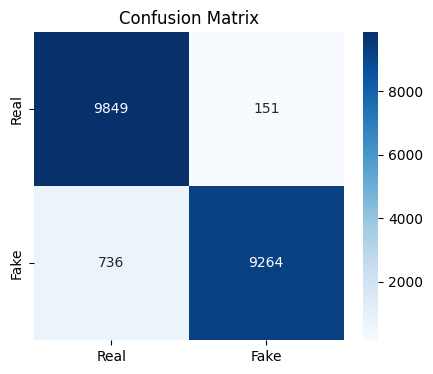

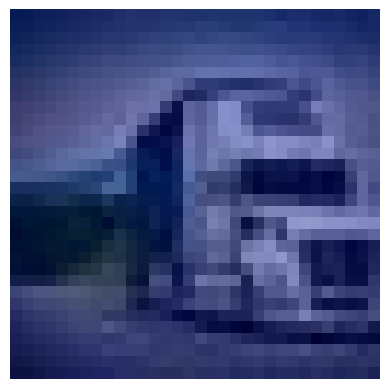

GradCAM saved!


In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# ==============================
# PATHS
# ==============================
PROJECT_ROOT = ".."   # because notebook is inside notebooks/

BASE_PATH = PROJECT_ROOT
MODEL_PATH = os.path.join(PROJECT_ROOT, "model", "cifake_resnet18_latest.pth")
TEST_DIR = os.path.join(PROJECT_ROOT, "data", "test")

# ==============================
# DEVICE
# ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==============================
# LOAD DATASET
# ==============================
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

test_dataset = datasets.ImageFolder(TEST_DIR, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Classes:", test_dataset.classes)

# ==============================
# LOAD TRAINED MODEL
# ==============================
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, 2)

# load checkpoint robustly
checkpoint = torch.load(MODEL_PATH, map_location=device)
if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
    state_dict = checkpoint['state_dict']
else:
    state_dict = checkpoint
try:
    model.load_state_dict(state_dict)
except RuntimeError:
    from collections import OrderedDict
    new_state = OrderedDict()
    for k,v in state_dict.items():
        name = k.replace('module.', '') if k.startswith('module.') else k
        new_state[name] = v
    model.load_state_dict(new_state)

model.to(device)
model.eval()

print("Model loaded successfully")

# ==============================
# EVALUATION METRICS
# ==============================
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs,1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_preds, all_labels, zero_division=0) if len(set(all_preds))>0 else precision_score(all_labels, all_preds, zero_division=0)
rec = recall_score(all_labels, all_preds, zero_division=0)
f1 = f1_score(all_labels, all_preds, zero_division=0)

print("Accuracy:",acc)
print("Precision:",prec)
print("Recall:",rec)
print("F1:",f1)

# ==============================
# CONFUSION MATRIX
# ==============================
cm = confusion_matrix(all_labels, all_preds)
os.makedirs(os.path.join(BASE_PATH, "results", "metrics"), exist_ok=True)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real","Fake"],
            yticklabels=["Real","Fake"])
plt.title("Confusion Matrix")
plt.savefig(os.path.join(BASE_PATH, "results", "metrics", "confusion_matrix.png"))
plt.show()

# ==============================
# GRADCAM
# ==============================
features = None
def hook_fn(module, input, output):
    global features
    features = output

model.layer4.register_forward_hook(hook_fn)

images, labels = next(iter(test_loader))
images = images.to(device)

output = model(images)

heatmap = torch.mean(features, dim=1)[0].cpu().detach().numpy()
heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)+1e-8
heatmap = cv2.resize(heatmap,(32,32))

# unnormalize image for display
mean = np.array(stats[0])
std = np.array(stats[1])
img = images[0].cpu().permute(1,2,0).numpy()
img = (img * std) + mean
img = np.clip(img,0,1)

os.makedirs(os.path.join(BASE_PATH, "results", "gradcam"), exist_ok=True)
plt.imshow(img)
plt.imshow(heatmap, cmap="jet", alpha=0.4)
plt.axis("off")
plt.savefig(os.path.join(BASE_PATH, "results", "gradcam", "heatmap.png"))
plt.show()

print("GradCAM saved!")